In [45]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_recall_curve, auc

import src.evaluation.utils as u
import src.globals as g

from src.methods.methods import calc_methods

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Calculate results if not done yet
df_imu = pd.read_parquet(g.path_imu)

In [9]:
 # Calculate results if not done yet
df_results = calc_methods(df_imu, verbose=True)
df_results.to_parquet(g.path_imu_results)

calculating (m)z-scores
calculating lof
Fitting lof_acceleration
Fitting lof_gravity
Fitting lof_gyroscope
Fitting lof_magnetic
Fitting lof_rotation
calculating if
Fitting if_acceleration
Fitting if_gravity
Fitting if_gyroscope
Fitting if_magnetic
Fitting if_rotation


In [2]:
df_results = pd.read_parquet(g.path_imu_results)


In [5]:
df_anomalous = df_results[['seqid', 'anomaly']].groupby('seqid').first().reset_index()
df_anomalous['anomaly_syn'] = df_anomalous['seqid'].str.split('|').str[2]

df_anomalous['anomalous'] = (df_anomalous['anomaly'] != 'none')
df_anomalous = df_anomalous.drop(columns=['anomaly'])


In [24]:
def calc_and_plot_sensor(sensor, precentile, f1=False):
    columns = u._get_sensor_columns(sensor)
    thresholds = [df_results[col].quantile(precentile) for col in columns]

    df_series = u.count_by_thresholds(df_results, columns, thresholds)
    df_series = df_series.merge(df_anomalous, on='seqid')

    u.plot_rpcurves(df_series, columns, title=sensor, f1=f1)
    

f:\edmo-project\Processing\src\evaluation\utils.py:45: RuntimeWarning: invalid value encountered in divide
  


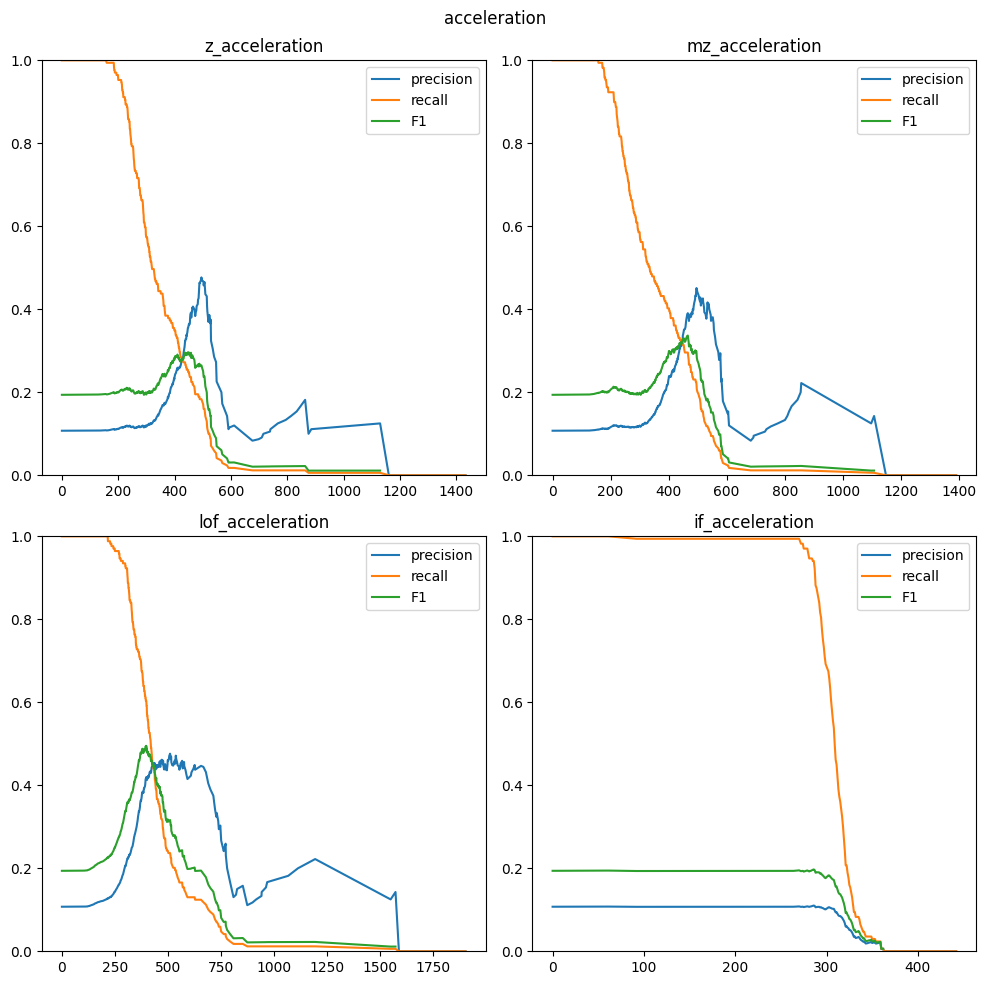

f:\edmo-project\Processing\src\evaluation\utils.py:45: RuntimeWarning: invalid value encountered in divide
  


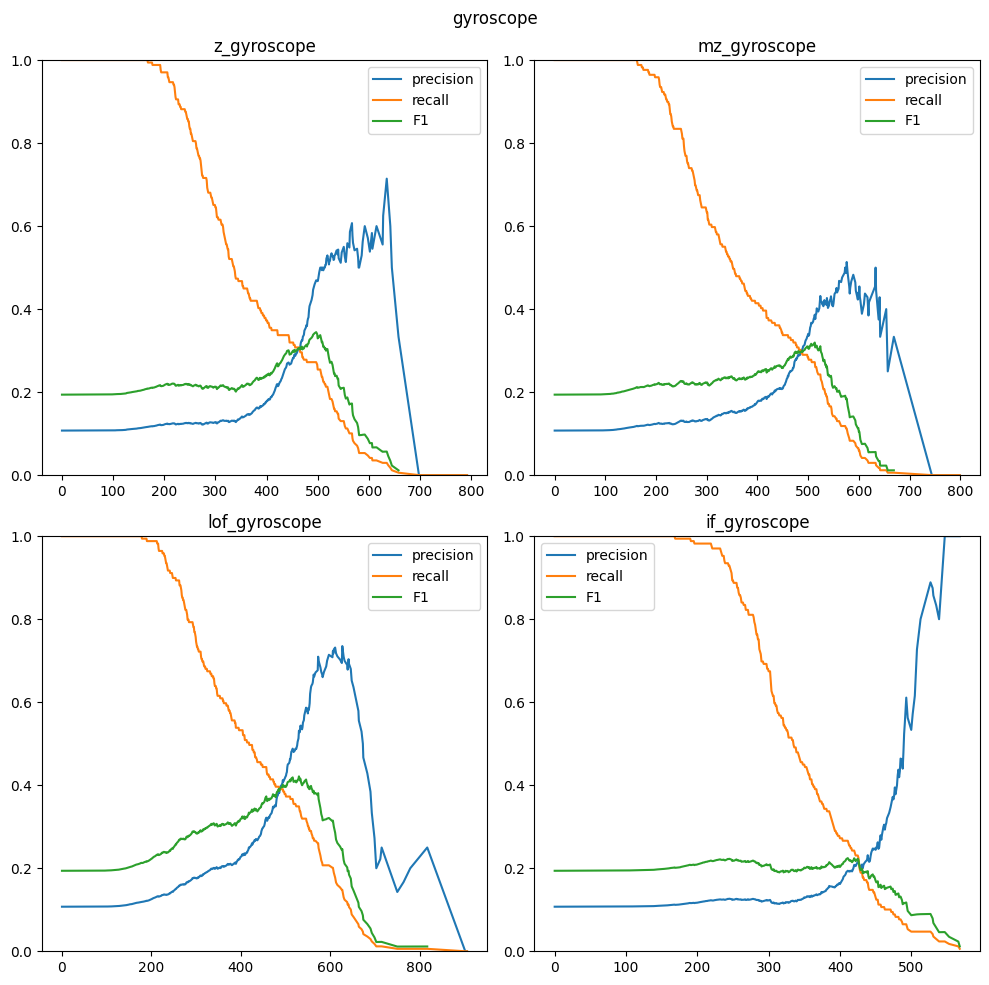

f:\edmo-project\Processing\src\evaluation\utils.py:45: RuntimeWarning: invalid value encountered in divide
  


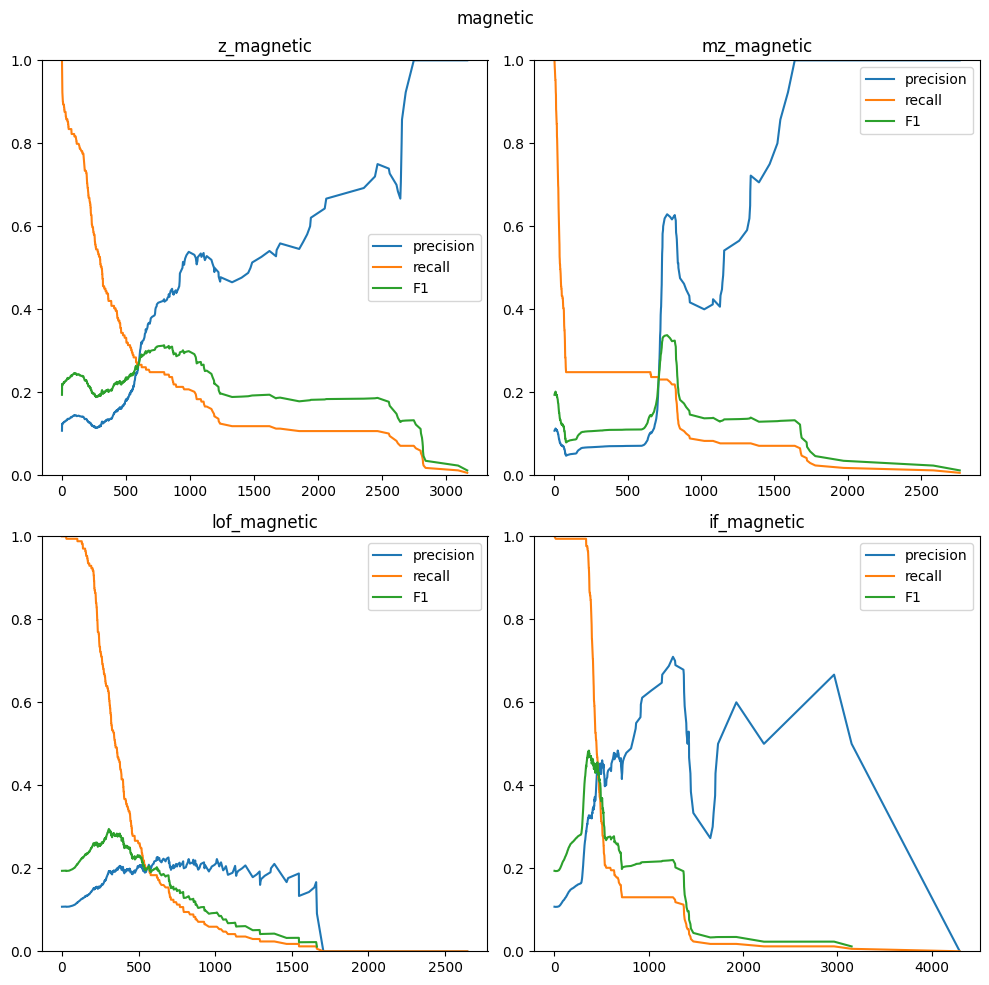

In [28]:
quantile = 0.90

calc_and_plot_sensor("acceleration", quantile, f1=True)
calc_and_plot_sensor("gyroscope", quantile, f1=True)
calc_and_plot_sensor("magnetic", quantile, f1=True)

In [67]:
def calc_rpcurves_aurps(sensor):
    quantile=0.9
    columns = u._get_sensor_columns(sensor)
    thresholds = [df_results[col].quantile(quantile) for col in columns]

    df_series = u.count_by_thresholds(df_results, columns, thresholds)
    df_series = df_series.merge(df_anomalous, on='seqid')

    rpcurves = u._calc_rpccurves(df_series, columns)
    aurps = {key : auc(rpc[1], rpc[0]) for (key, rpc) in rpcurves.items()}
    return (rpcurves, aurps)


stuff = {sensor : calc_rpcurves_aurps(sensor) for sensor in ['acceleration', 'gyroscope', 'magnetic']}


{'acceleration': ({'z_acceleration': (array([0.10736976, 0.10743802, 0.10750636, 0.10757479, 0.10764331,
       0.10771192, 0.10778061, 0.10784939, 0.10791826, 0.10798722,
       0.10805627, 0.1081254 , 0.10826393, 0.10833333, 0.10840282,
       0.1084724 , 0.10854207, 0.10803859, 0.10810811, 0.10817772,
       0.1083871 , 0.10845707, 0.10866753, 0.10880829, 0.10887881,
       0.10902012, 0.10916179, 0.10944625, 0.10958904, 0.10966057,
       0.10980392, 0.10994764, 0.11009174, 0.1103086 , 0.11052632,
       0.11067194, 0.11074489, 0.11111111, 0.11133201, 0.11147976,
       0.11059294, 0.11007338, 0.11036789, 0.10984595, 0.11014103,
       0.11051213, 0.11073599, 0.11103588, 0.11118644, 0.1107337 ,
       0.11111111, 0.11149111, 0.11164384, 0.11187371, 0.11218169,
       0.11141869, 0.11172797, 0.11188325, 0.1126662 , 0.11330049,
       0.1135402 , 0.11410347, 0.11442786, 0.11467236, 0.1150822 ,
       0.11541219, 0.11527378, 0.11577424, 0.11588921, 0.11501832,
       0.11544118, 0.115

In [69]:
sensor="magnetic"

def get_metrics_f1max(precision, recall, thresholds):
    f1 = u._calc_f1(precision, recall)
    argmax = np.nanargmax(f1)
    aurps = auc(recall, precision)

    return [round(x, 3) for x in [precision[argmax], recall[argmax], f1[argmax], aurps]]

rpcurves = stuff[sensor][0]
print(
    get_metrics_f1max(*rpcurves[f'z_{sensor}']),
    get_metrics_f1max(*rpcurves[f'mz_{sensor}']),
    get_metrics_f1max(*rpcurves[f'lof_{sensor}']),
    get_metrics_f1max(*rpcurves[f'if_{sensor}'])
    )

[0.424, 0.249, 0.313, 0.274] [0.629, 0.231, 0.338, 0.226] [0.193, 0.621, 0.295, 0.18] [0.328, 0.923, 0.484, 0.401]


f:\edmo-project\Processing\src\evaluation\utils.py:45: RuntimeWarning: invalid value encountered in divide
  
f:\edmo-project\Processing\src\evaluation\utils.py:45: RuntimeWarning: invalid value encountered in divide
  


In [ ]:
'z_acceleration'